<a href="https://colab.research.google.com/github/hieumenbox/GoogleColab/blob/main/pH_sensor_LSTM_annomably_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import math
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
import pandas as pd
df = pd.read_csv('pH_sensor_data_2.csv')
df

,Timestamp,Time,Temperature,Hudmidity,pH,Test_value_mean,Pred_value,MAE,Status
0,25/05/2021 15:23:40,15:23:40,29.4,73.3,6.20,6.18,6.20,0.02,Normal
1,25/05/2021 15:23:50,15:23:50,29.4,73.2,6.17,6.18,6.25,0.06,Normal
2,25/05/2021 15:24:00,15:24:00,29.4,73.2,6.18,6.17,6.17,0.00,Normal
3,25/05/2021 15:24:10,15:24:10,29.4,73.1,6.20,6.17,6.20,0.03,Normal
4,25/05/2021 15:24:20,15:24:20,29.4,73.2,6.14,6.17,6.15,0.01,Normal
...,...,...,...,...,...,...,...,...,...
2201,25/05/2021 21:30:30,21:30:30,28.5,72.6,6.36,0.00,0.00,0.00,Normal
2202,25/05/2021 21:30:40,21:30:40,28.5,72.6,6.30,0.00,0.00,0.00,Normal
2203,25/05/2021 21:30:50,21:30:50,28.5,72.6,6.39,0.00,0.00,0.00,Normal
2204,25/05/2021 21:31:00,21:31:00,28.5,72.6,6.26,0.00,0.00,0.00,Normal


In [ ]:
df = df[['Timestamp', 'pH']]
df.head()

,Timestamp,pH
0,25/05/2021 15:23:40,6.20
1,25/05/2021 15:23:50,6.17
2,25/05/2021 15:24:00,6.18
3,25/05/2021 15:24:10,6.20
4,25/05/2021 15:24:20,6.14


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S')
df.set_index('Timestamp', inplace=True)
df.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


pH    float64
dtype: object

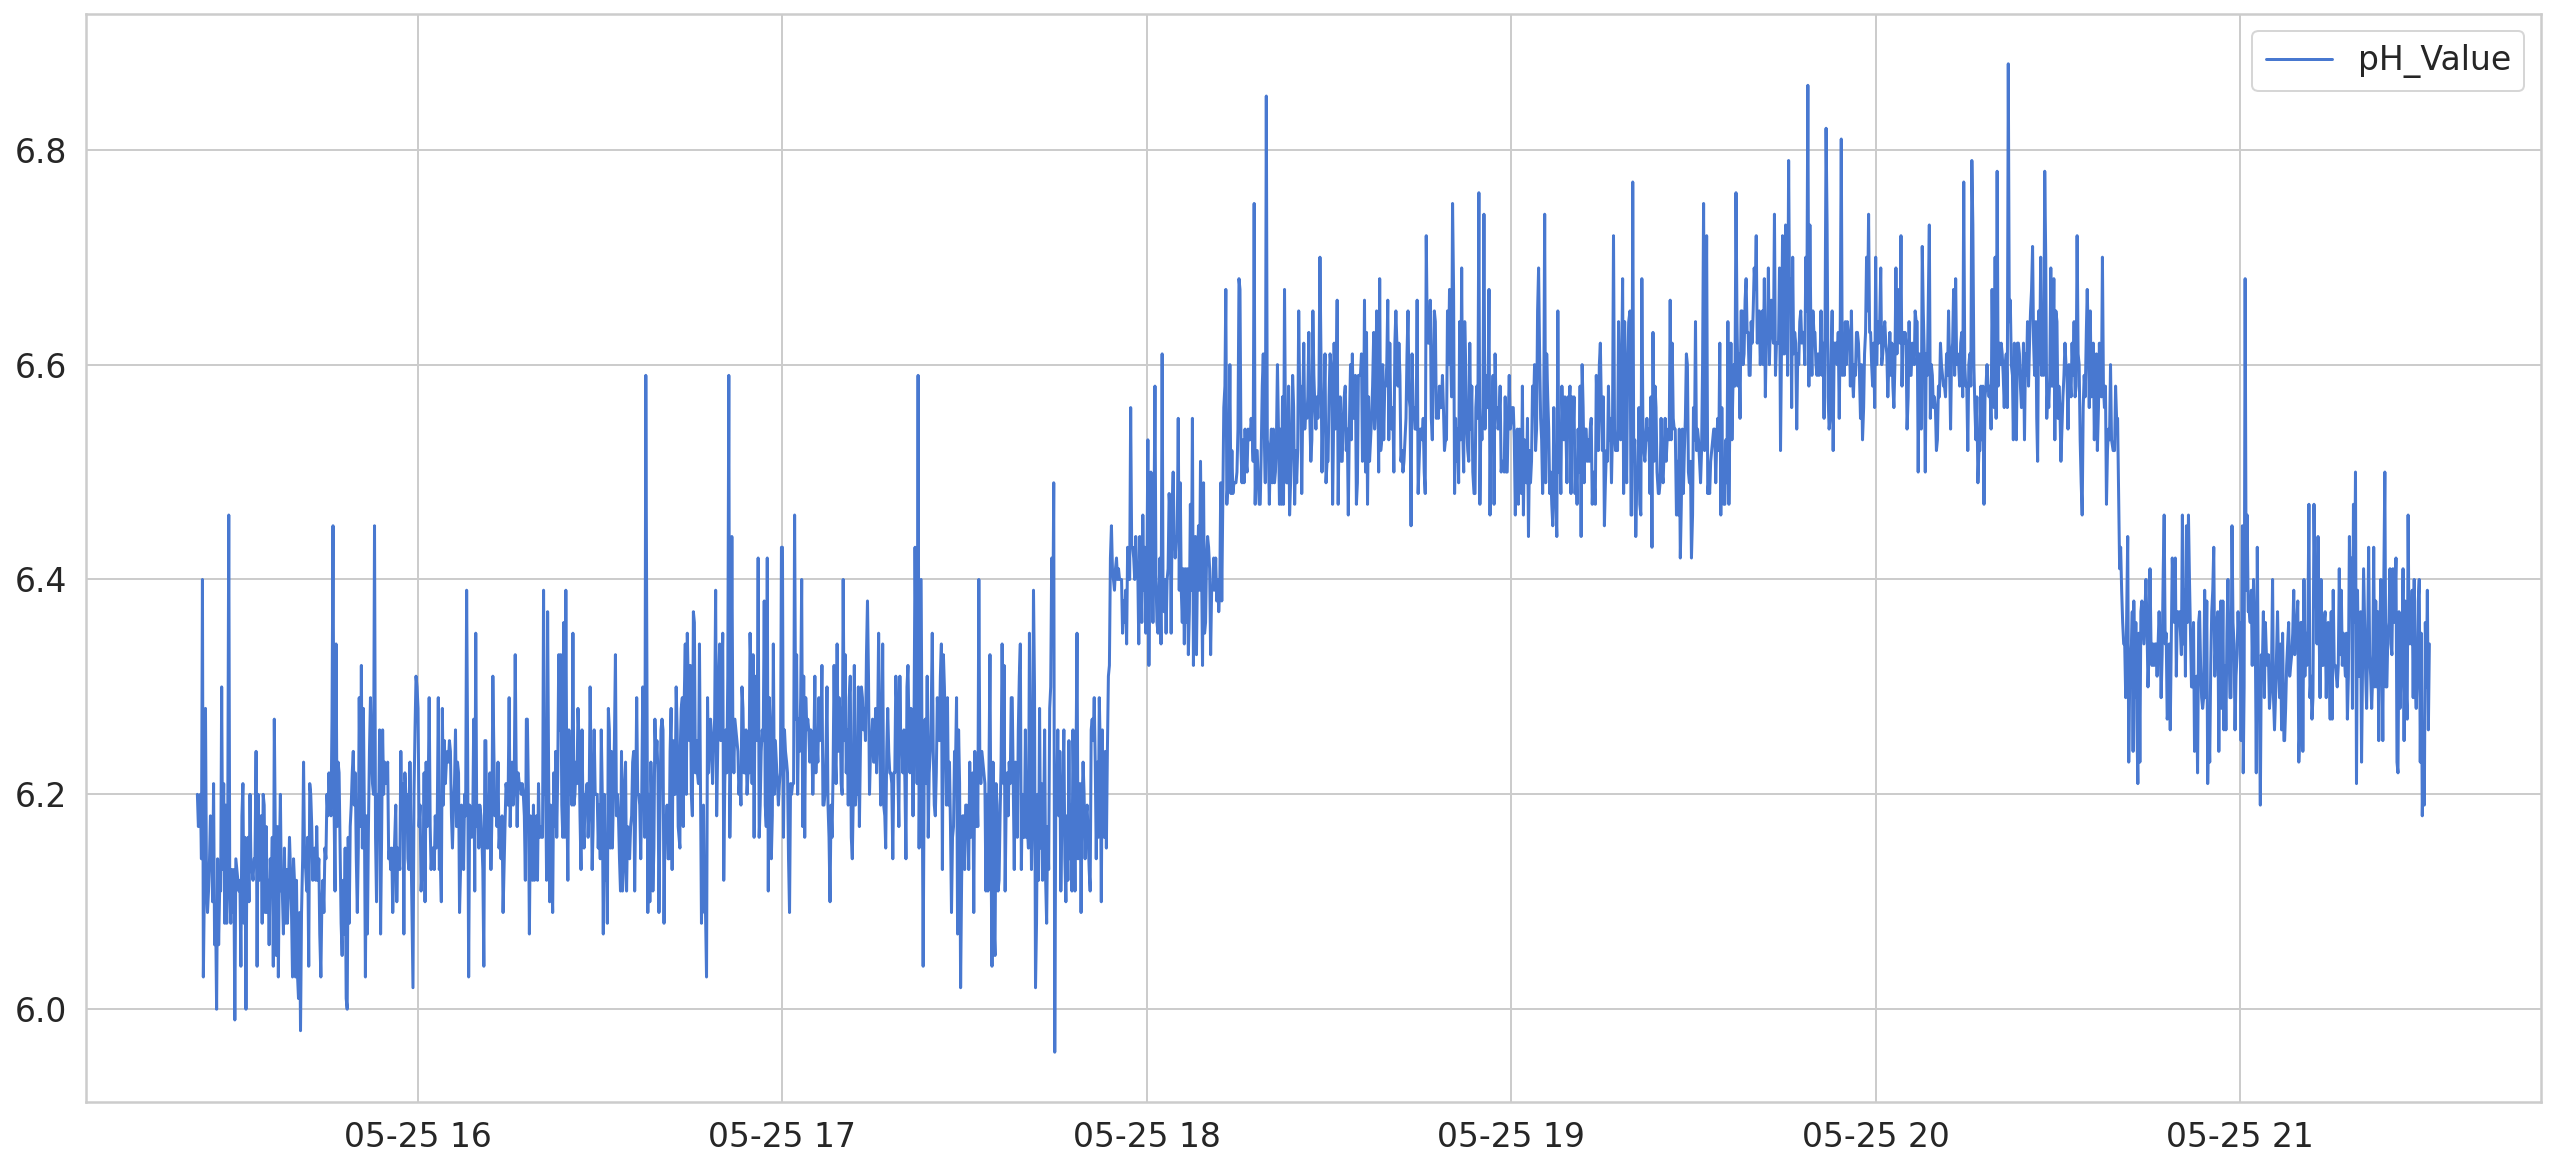

In [ ]:
plt.plot(df, label='pH_Value')
plt.legend();

In [ ]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size 
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(2095, 1) (111, 1)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['pH']])

train['pH'] = scaler.transform(train[['pH']])
test['pH'] = scaler.transform(test[['pH']])
test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,pH
Timestamp,
2021-05-25 21:12:50,0.305846
2021-05-25 21:13:00,-0.119441
2021-05-25 21:13:10,-0.491566
2021-05-25 21:13:20,0.093203
2021-05-25 21:13:30,-0.332084


In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['pH']], train.pH, TIME_STEPS)
X_test, y_test = create_dataset(test[['pH']], test.pH, TIME_STEPS)
print(X_train.shape)
print(X_test.shape)

(2085, 10, 1)
(101, 10, 1)


In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [ ]:

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
59/59 [==============================] - 3s 16ms/step - loss: 0.4515 - val_loss: 0.2792
Epoch 2/10
59/59 [==============================] - 0s 5ms/step - loss: 0.3228 - val_loss: 0.2715
Epoch 3/10
59/59 [==============================] - 0s 5ms/step - loss: 0.3145 - val_loss: 0.2899
Epoch 4/10
59/59 [==============================] - 0s 5ms/step - loss: 0.3061 - val_loss: 0.2925
Epoch 5/10
59/59 [==============================] - 0s 5ms/step - loss: 0.2991 - val_loss: 0.2955
Epoch 6/10
59/59 [==============================] - 0s 5ms/step - loss: 0.2993 - val_loss: 0.2916
Epoch 7/10
59/59 [==============================] - 0s 5ms/step - loss: 0.2984 - val_loss: 0.2977
Epoch 8/10
59/59 [==============================] - 0s 5ms/step - loss: 0.2947 - val_loss: 0.3264
Epoch 9/10
59/59 [==============================] - 0s 5ms/step - loss: 0.2971 - val_loss: 0.3083
Epoch 10/10
59/59 [==============================] - 0s 5ms/step - loss: 0.2885 - val_loss: 0.3006


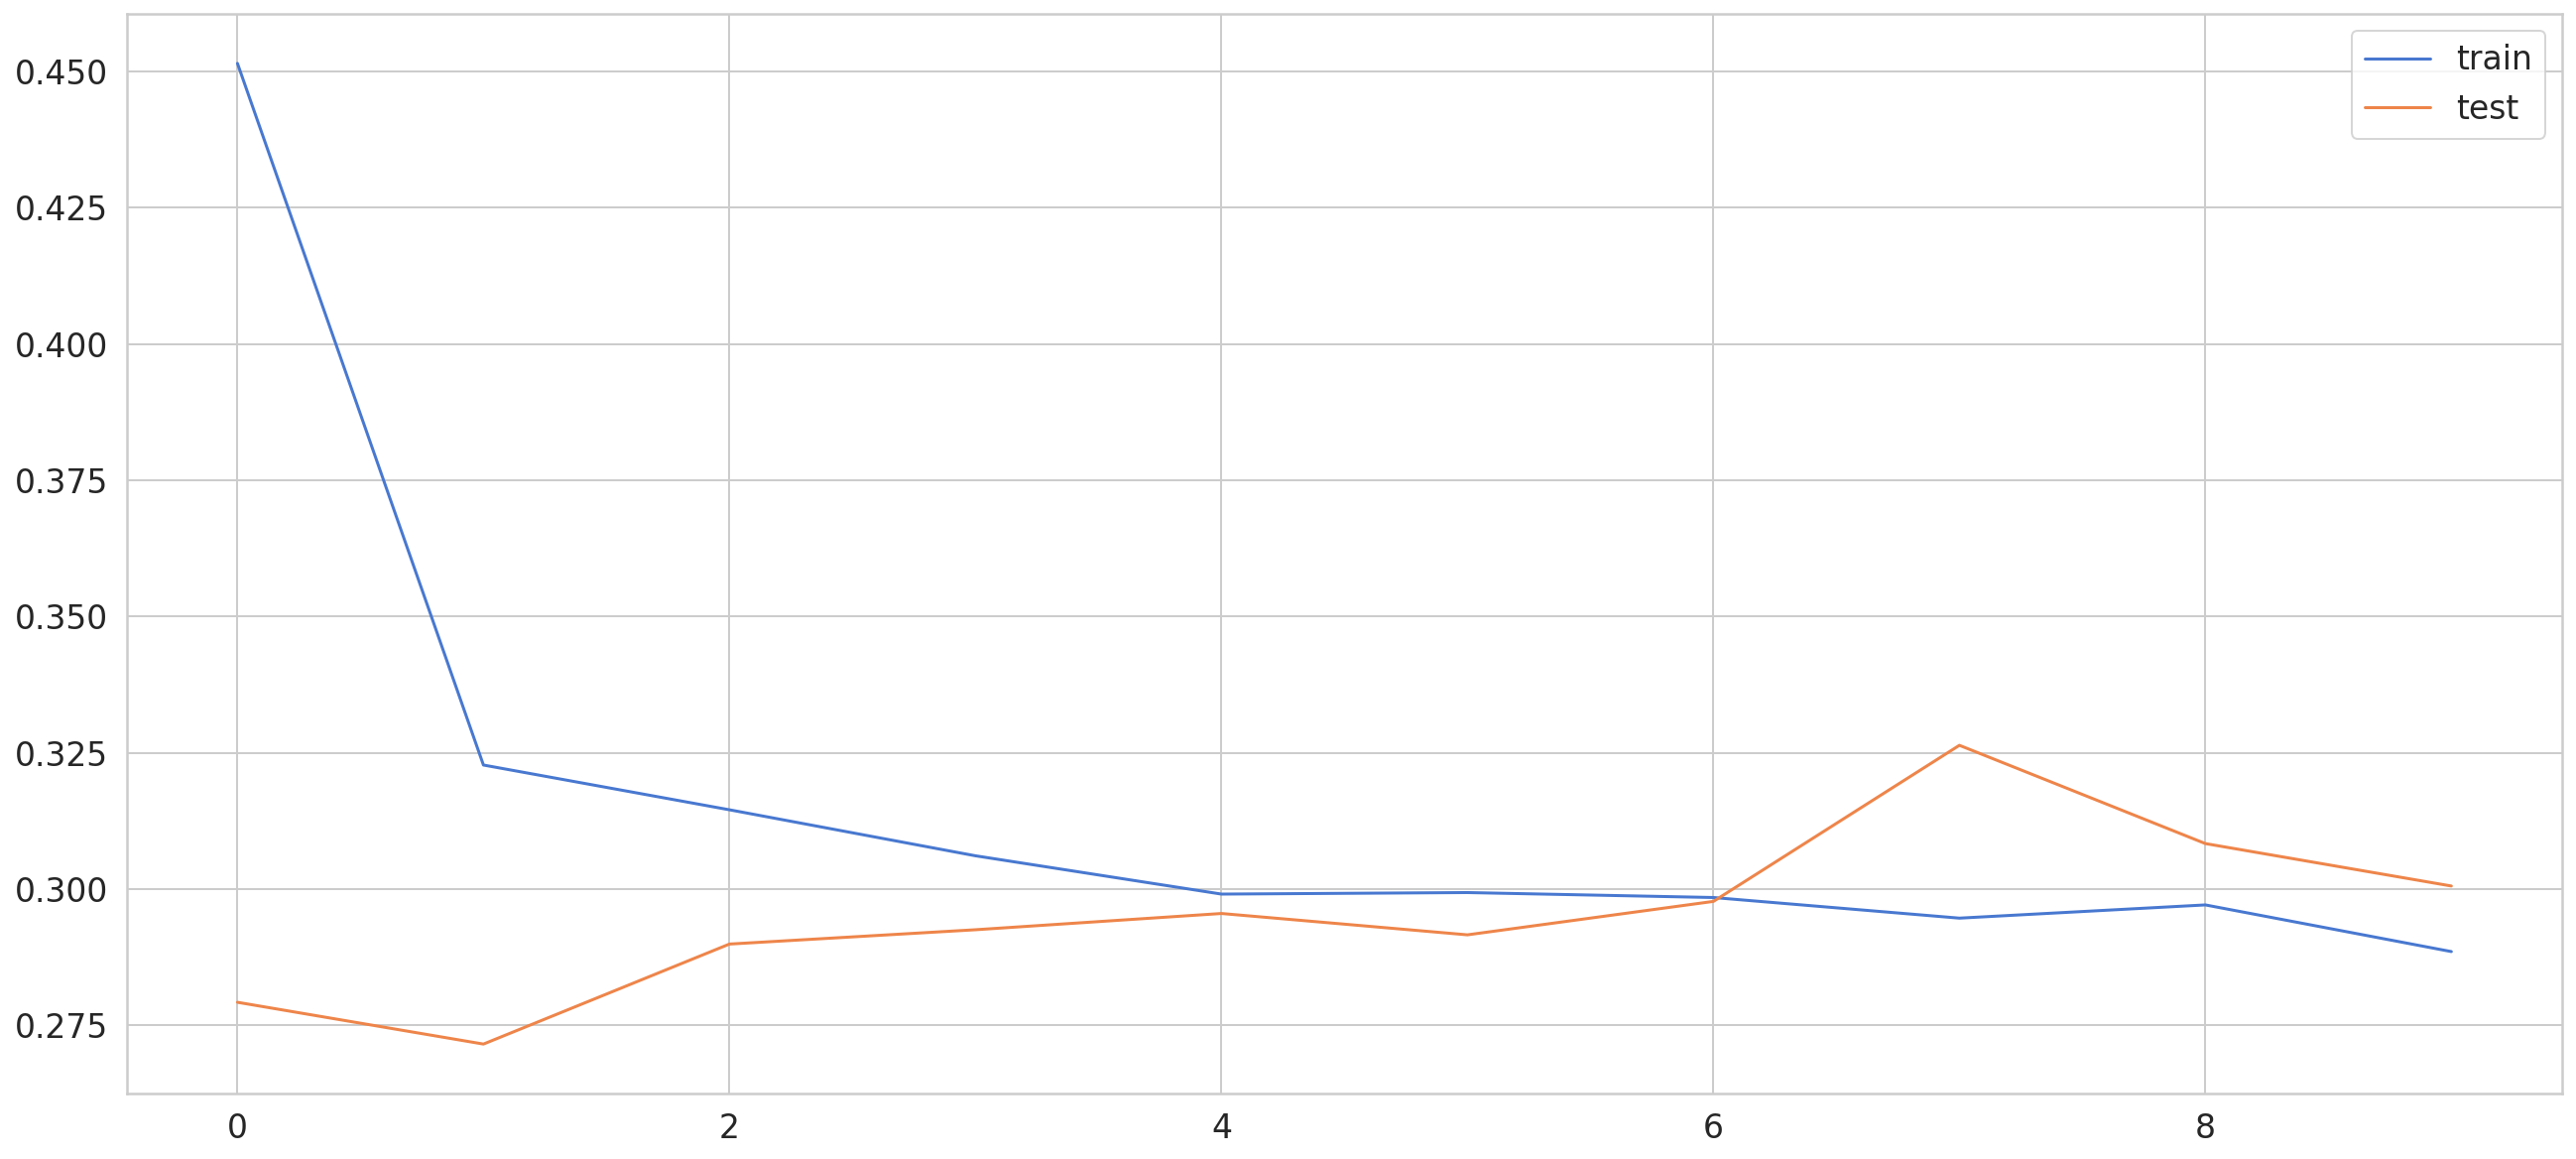

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

Training loss: 0.258768627685788



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


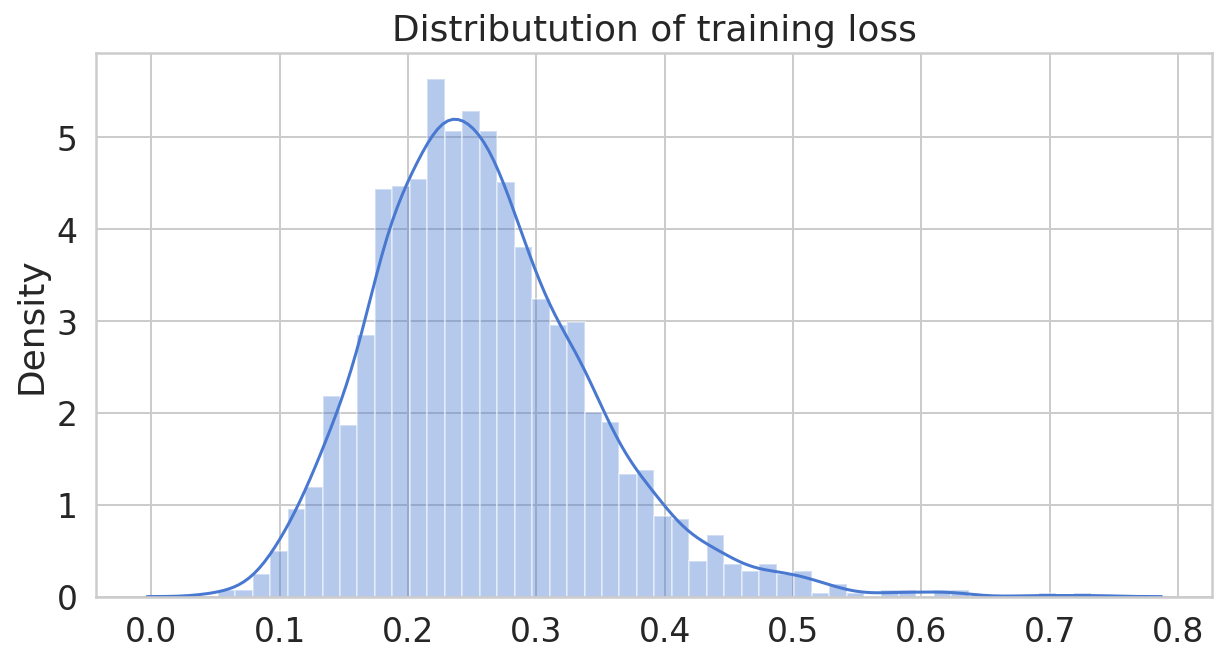

In [ ]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
avg_loss = train_mae_loss.mean()
print('Training loss:', avg_loss);
print()
plt.figure(figsize = (10, 5))
sns.distplot(train_mae_loss, bins=50, kde=True);
plt.title('Distributution of training loss')
plt.show();

In [ ]:
threshold = np.mean(train_mae_loss) + np.std(train_mae_loss)
print(threshold)

0.34337690585597913


In [ ]:
# MAE on the test data:
y_pred = model.predict(X_test)
print('Predict shape:', y_pred.shape); print();
mae = np.mean(np.abs(y_pred - X_test), axis=1)
# reshaping prediction
pred = y_pred.reshape((y_pred.shape[0] * y_pred.shape[1]),
                      y_pred.shape[2])
print('Prediction:', pred.shape); print();
print('Test data shape:', X_test.shape); print();
# reshaping test data
X_test = X_test.reshape((X_test.shape[0] * X_test.shape[1]), 
                        X_test.shape[2])
print('Test data:', X_test.shape); print();
# error computation
errors = X_test - pred
print('Error:', errors.shape); print();
# rmse on test data
RMSE = np.sqrt(((X_test - pred) ** 2).mean())
print('Test RMSE: %.3f' % RMSE);



Predict shape: (101, 10, 1)

Prediction: (1010, 1)

Test data shape: (101, 10, 1)

Test data: (1010, 1)

Error: (1010, 1)

Test RMSE: 0.336


In [ ]:
dist = np.linalg.norm (X_test - pred, axis=1);
scores = dist.copy();
print('Score: ', scores.shape);
scores.sort();
cut_off = int(0.8*len(scores));
print('Cutoff value: ', cut_off);
threshold = scores[cut_off];
print ('Threshold value: ',threshold);
# print(scores[1000])

Score:  (1010,)
Cutoff value:  808
Threshold value:  0.4413028440588238


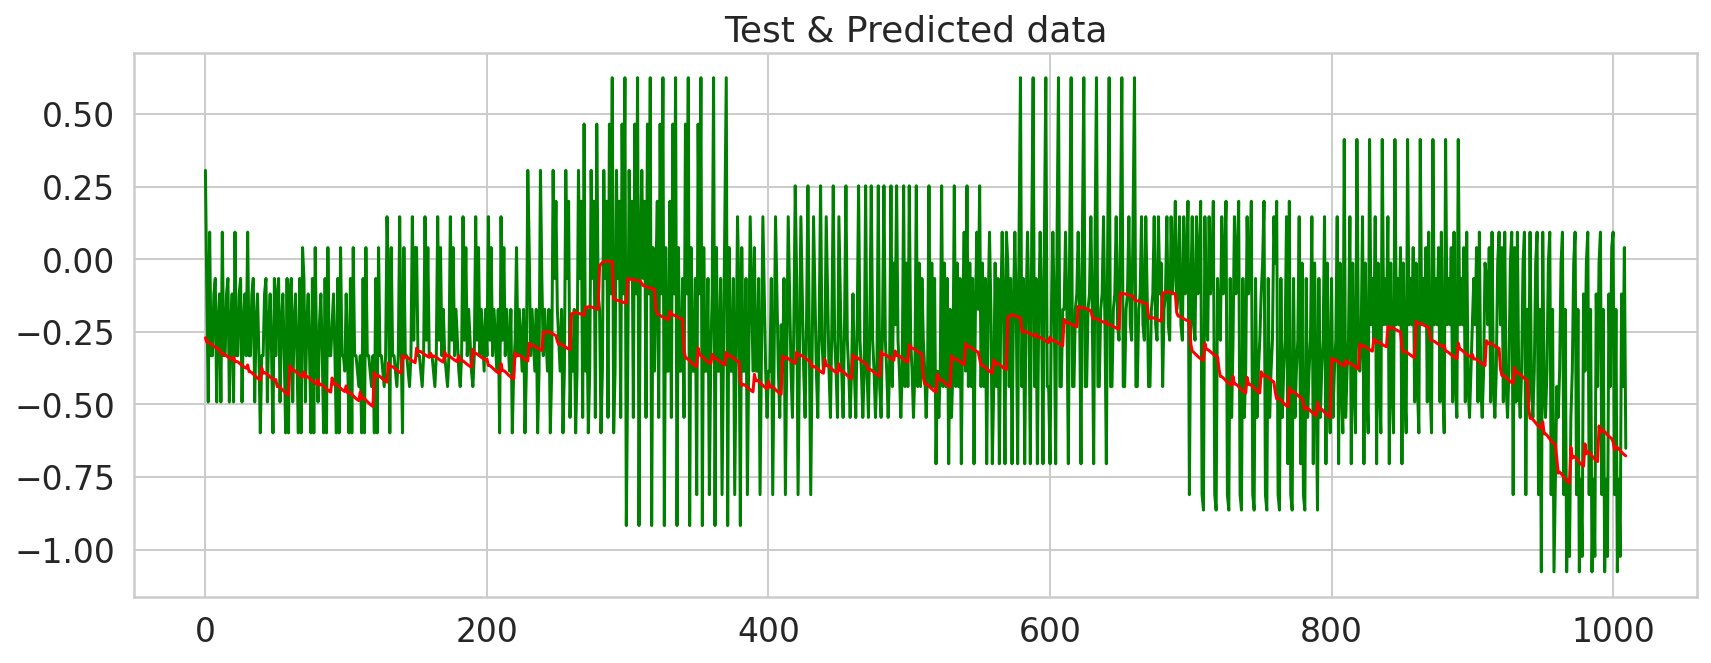

In [ ]:
plt.figure(figsize= (14,5))
plt.plot(X_test, color ='green')
plt.plot (pred, color ='red')
plt.title("Test & Predicted data")
plt.show();

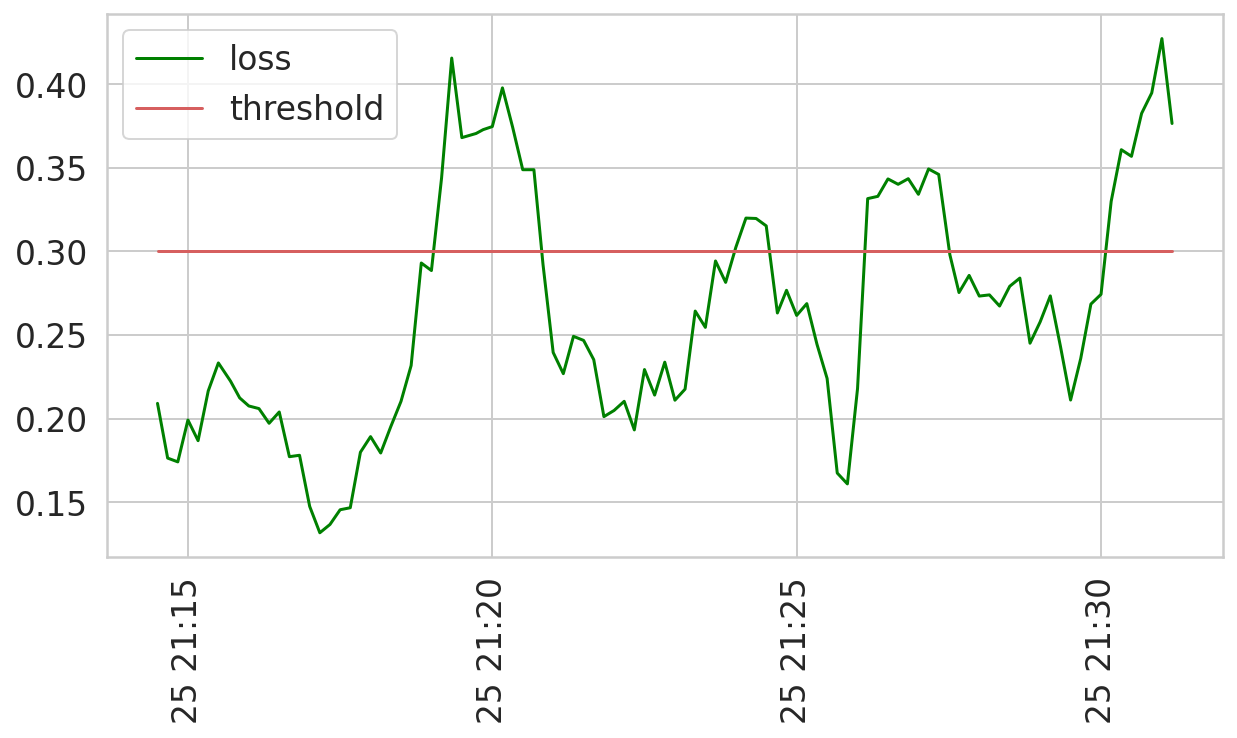

In [ ]:
threshold = 0.3

score= pd.DataFrame(index=test[TIME_STEPS:].index)
score['loss'] = mae
score['threshold'] = threshold
score['anomaly'] = score.loss > score.threshold
score['pH'] = test[TIME_STEPS:].pH

plt. figure (figsize = (10,5))
plt.plot(score. index, score['loss'], color ='green', label = 'loss')
plt.plot(score.index, score['threshold'], color = 'r', label='threshold')
plt.xticks(rotation=90)
plt.legend();

In [ ]:
anomalies = score[score['anomaly'] == True]
x = pd.DataFrame(anomalies.pH)
x = pd.DataFrame(scaler.inverse_transform(x))
x.index = anomalies.index
x.rename(columns = {0: 'inverse_pH'}, inplace = True)
anomalies = anomalies.join(x, how = 'left')
anomalies = anomalies.drop(columns=['pH'], axis=1)
anomalies.tail(10)

,loss,threshold,anomaly,inverse_pH
Timestamp,,,,
2021-05-25 21:27:00,0.334053,0.3,True,6.25
2021-05-25 21:27:10,0.349224,0.3,True,6.38
2021-05-25 21:27:20,0.345931,0.3,True,6.30
2021-05-25 21:30:10,0.329832,0.3,True,6.24
2021-05-25 21:30:20,0.360720,0.3,True,6.19
2021-05-25 21:30:30,0.356754,0.3,True,6.36
2021-05-25 21:30:40,0.382426,0.3,True,6.30
2021-05-25 21:30:50,0.394696,0.3,True,6.39
2021-05-25 21:31:00,0.427148,0.3,True,6.26


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


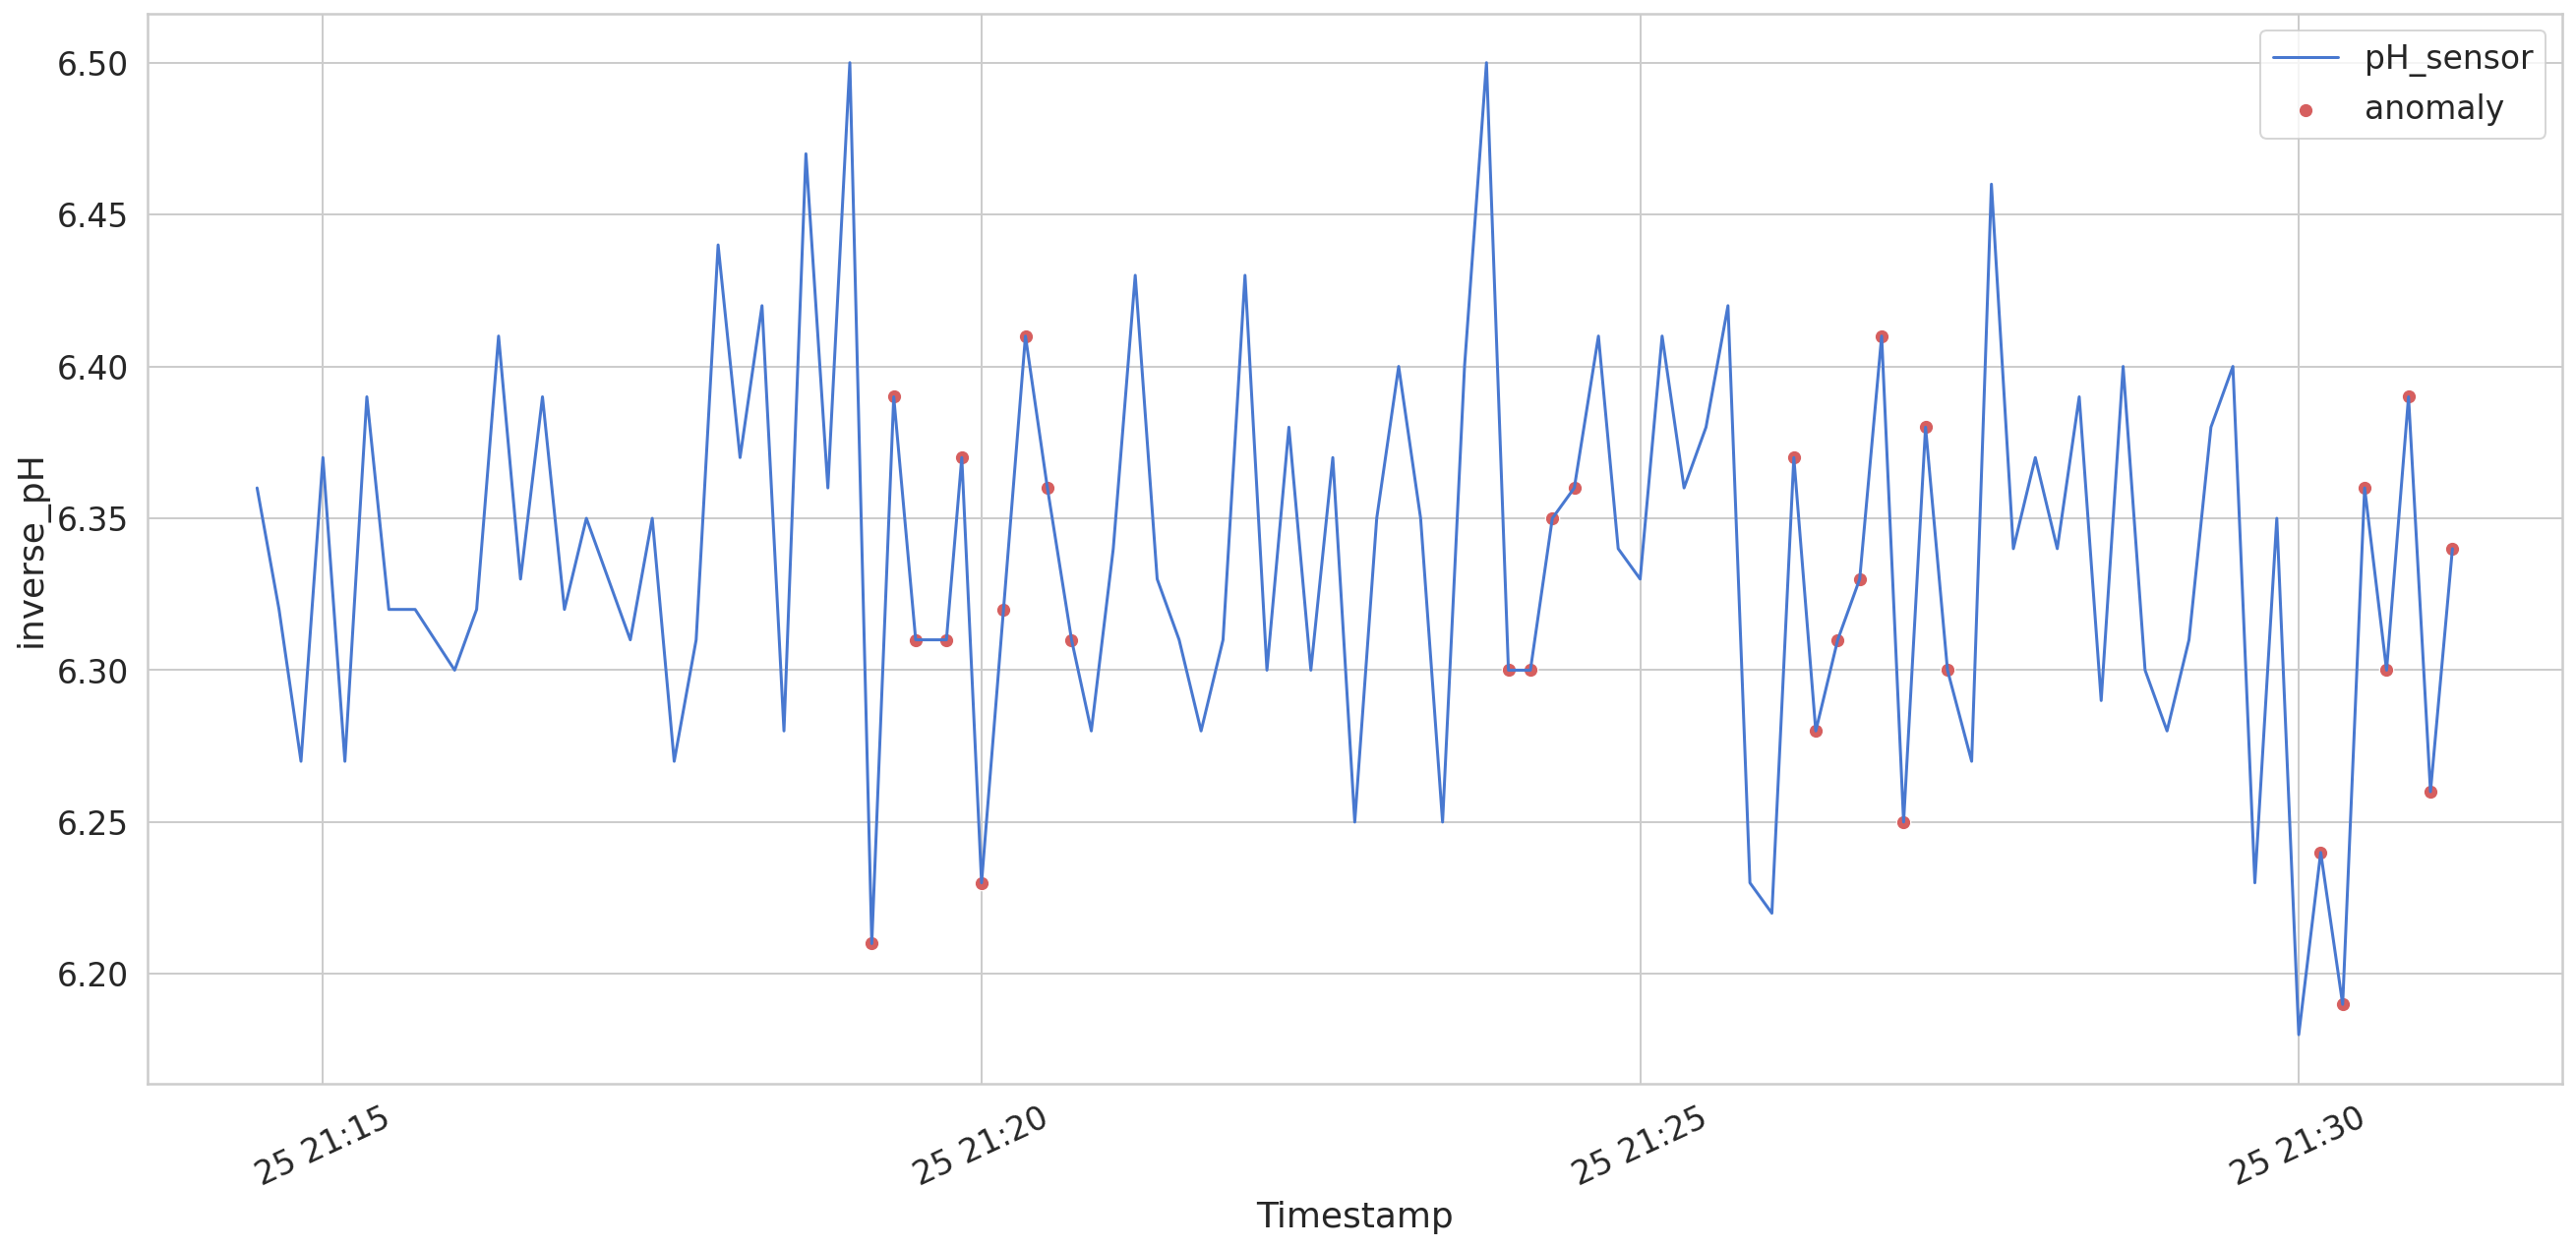

In [ ]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].pH), 
  label='pH_sensor'
);

sns.scatterplot(
  anomalies.index,
  anomalies.inverse_pH,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

##Export Model

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
model.save('/content/gdrive/MyDrive/Model3.h5')